# Project: Investigate a Medical Appointment No Shows Dataset

## Table of Contents

* <a href="#intro">Introduction</a>
* <a href="#wrangling">Data Wrangling</a>
* <a href="#eda">Exploratory Data Analysis</a>
    * <a href="#rq1">Research Question 1: Which features have strongest correlation with patients showing up?</a>
    * <a href="#rq2">Research Question 2: Is there association between medical conditions reported in this dataset and patients showing up?</a>
    * <a href="#rq3">Research Question 3: How tendencies of patients showing up change as number of days patients have to wait for appointment increases?</a>
    * <a href="#rq4">Research Question 4: Do different days of week have different tendencies of patients showing up?</a>
    * <a href="#rq5">Research Question 5: Are there any neighborhoods with significantly different tenencies of patients showing up?</a>
* <a href="#conclusions">Conclusions</a>

<a id='intro'></a>
## Introduction

The dataset I chose is [Medical Appointment No Shows dataset from Kaggle](https://www.kaggle.com/joniarroba/noshowappointments). It has below features, holding variables about patient scheduled appointments in Brasil. Main feature is `No-Show` telling us if patient showed up to scheduled appointment or not.

* `PatientId` - Identification of a patient;
* `AppointmentID` - Identification of each appointment;
* `Gender` - M=Male, F=Female;
* `AppointmentDay` - The scheduled day of appointment;
* `ScheduledDay` - The day when appointment was scheduled;
* `Age` - How old is the patient;
* `Neighbourhood` - Where the appointment takes place;
* `Scholarship` - 1=Ture, 0=False;
* `Hipertension` - 1=Ture, 0=False;
* `Diabetes` - 1=Ture, 0=False;
* `Alcoholism` - 1=Ture, 0=False;
* `Handcap` - 0 to 4, 0=No handicap;
* `SMS_received` - 1=Ture, 0=False;
* `No-show` - No=Showed up, Yes=Did not show up.

### Questions about this dataset:
* <a href="#rq1">Which features have strongest correlation with patients showing up?</a>
* <a href="#rq2">Is there association between medical conditions reported in this dataset and patients showing up?</a>
* <a href="#rq3">How tendencies of patients showing up change as number of days patients have to wait for appointment increases?</a>
* <a href="#rq4">Do different days of week have different tendencies of patients showing up?</a>
* <a href="#rq5">Are there any neighborhoods with significantly different tenencies of patients showing up?</a>

In [1]:
import sys
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt, gridspec
import seaborn as sns

sns.set(style = "whitegrid", color_codes = True)

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

Let's load the data and see what we can learn without in-depth analysis.

### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


* There are no `null` values in the dataset;
* `ApointmentID` and `PatientId` could be integers, but I'd rather have them as strings so pandas treets them as categorical values;
* `ScheduledDay` and `AppointmentDay` seem to be string, I'd like them to be dates;
* `No-show` could be converted to 0-1 values.

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


* Min value of `Age` is -1. This suggests we have some empty values there;
* `Scholarship`, `Hipertension`, `Diabetes`, `Alcoholism` have small mean values, informing us these are rare conditions;
* `SMS_received` mean of 0.32 informs us 32% patients vere sent SMS reminders. This is lower than expected value. 

In [5]:
# check unique value counts to see if there are any unexpected figures
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

* Number of `PatientId`s is a little over the half of `AppointmentId`s and `AppointmentId`s match row count. That looks fine;
* We have 103549 unique `ScheduledDay` values - almost all of them are unique, while we only have 27 unique `AppointmentDay` values. There's something suspicious here;
* `Handcap` has 5 unique values. Initially expected to see 2.

In [6]:
# take a closer look at suspicious columns
print(df['AppointmentDay'].unique(),
      df['ScheduledDay'].unique()[:30],
      df['Handcap'].unique(),
      sep='\n\n')

['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-25T00:00:00Z'
 '2016-05-11T00:00:00Z' '2016-05-18T00:00:00Z' '2016-05-14T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-03T00:00:00Z' '2016-06-06T00:00:00Z'
 '2016-06-07T00:00:00Z' '2016-06-01T00:00:00Z' '2016-06-08T00:00:00Z']

['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z'
 '2016-04-29T17:29:31Z' '2016-04-29T16:07:23Z' '2016-04-27T08:36:51Z'
 '2016-04-27T15:05:12Z' '2016-04-27T15:39:58Z' '2016-04-29T08:02:16Z'
 '2016-04-27T12:48:25Z' '2016-04-27T14:58:11Z' '2016-04-26T08:44:12Z'
 '2016-04-28T11:33:51Z' '2016-04-28T14:52:07Z' '2016-04-28T10:06:24Z'
 '2016-04-26T08:47

* `AppointmentDay` has no time, while `ScheduledDay` has precise time set;
* `Handcap` is a range of integers. Probably some disability scale.

Let's check how patients distribute over appointment count they had to see if there's a lot of patients that had more than 1 appointment.

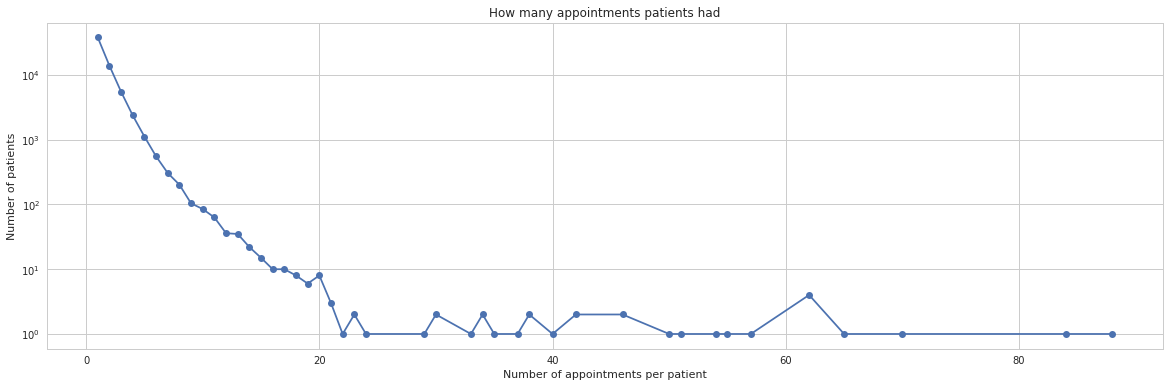

In [7]:
patient_counts_by_appointment_counts = (df.groupby('PatientId')
                                       .size()
                                       .value_counts()
                                       .reset_index()
                                       .rename(columns = {'index': 'AppointmentCount',
                                                          0: 'PatientCount'})
                                       .sort_values('AppointmentCount'))

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_yscale('log')
plt.plot(patient_counts_by_appointment_counts['AppointmentCount'], 
         patient_counts_by_appointment_counts['PatientCount'],
         'o-')
plt.title('How many appointments patients had')
plt.xlabel('Number of appointments per patient')
plt.ylabel('Number of patients');

It looks like we have a lot of extreme values for how many appointments patients tend to have. Some patients had over 80 appointments over 27 days we have in our dataset. I don't expect them to distort analysis results, but it would be interesting to look at them separately to see if they differ from the rest of sample in any significant way.

### Data Cleaning

Needed improvements to dataset:

* `AppointmentID`: rename to `AppointmentId`, convert from int to string;
* `PatientId`: convert from float to string;
* `ScheduledDay`: convert from string to date, truncate to days;
* `AppointmentDay`: convert from string to date;
* `No-show`: convert 'yes'-'no' to integer 0-1 (inverse), rename to `Show_up`;
* `Handcap`: rename to `Handicap`;
* `Age`: Remove rows with `Age` < 0.


In [8]:
df_cleaned = df

In [9]:
# convert data types and rename columns
df_cleaned['AppointmentID'] = df_cleaned['AppointmentID'].astype(str)
df_cleaned['PatientId'] = df_cleaned['PatientId'].astype(str)
df_cleaned['ScheduledDay'] = pd.to_datetime(df_cleaned['ScheduledDay']).dt.floor('d')
df_cleaned['AppointmentDay'] = pd.to_datetime(df_cleaned['AppointmentDay'])
df_cleaned['Show_up'] = df_cleaned['No-show'].str.lower().str.contains('no').astype(int)
df_cleaned = df_cleaned.drop('No-show', axis=1)
df_cleaned.rename(columns = {'Handcap': 'Handicap',
                             'AppointmentID': 'AppointmentId'},
                  inplace = True)

In [10]:
# remove rows with invalid `Age`
df_cleaned = df_cleaned.query('Age >= 0')

In [11]:
# peek at dataset changes
df_cleaned.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show_up
0,2.98724998243e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,5.58997776694e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4.26296229995e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174.0,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8.84118644818e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1


In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110526 non-null object
AppointmentId     110526 non-null object
Gender            110526 non-null object
ScheduledDay      110526 non-null datetime64[ns]
AppointmentDay    110526 non-null datetime64[ns]
Age               110526 non-null int64
Neighbourhood     110526 non-null object
Scholarship       110526 non-null int64
Hipertension      110526 non-null int64
Diabetes          110526 non-null int64
Alcoholism        110526 non-null int64
Handicap          110526 non-null int64
SMS_received      110526 non-null int64
Show_up           110526 non-null int64
dtypes: datetime64[ns](2), int64(8), object(4)
memory usage: 12.6+ MB


In [13]:
df_cleaned.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Show_up
count,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,0.798066
std,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,0.401445
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


<a id='eda'></a>
## Exploratory Data Analysis

Let's start by adding some calculated columns to the dataset:

* `Appointment_day_of_week` to keep track of on what day of week appointment was scheduled;
* `Wait_days` to keep track of how many days patient had to wait for the appointment (difference between `ScheduleDay` and `AppointmentDay`).

In [14]:
df_cleaned['Appointment_day_of_week'] = df_cleaned['AppointmentDay'].dt.weekday
df_cleaned['Appointment_day_of_week_name'] = df_cleaned['AppointmentDay'].dt.weekday_name
df_cleaned['Wait_days'] = ((df_cleaned['AppointmentDay'] - df_cleaned['ScheduledDay']) / pd.offsets.Day(1)).astype(int)

In [15]:
# use our new column to see if there's any appointment scheduled after the fact
df_cleaned.query('Wait_days < 0')['AppointmentId'].count()

5

5 rows with `AppointmentDay` ahead of `ScheduledDay`. These need removing.

In [16]:
df_cleaned = df_cleaned.query('Wait_days >= 0')

<a id="rq1"></a>
### Research Question 1: Which features have strongest correlation with patients showing up?

In [17]:
# Compute the correlation matrix
corr = df_cleaned.corr()
# extract `Show_up` correlations to other features
corrr = corr.loc[:, ['Show_up']]
corrr['abs'] = corrr['Show_up'].abs()
corrr.sort_values('abs', ascending=False).query('index != "Show_up"')['Show_up']

Wait_days                 -0.186320
SMS_received              -0.126502
Age                        0.060320
Hipertension               0.035662
Scholarship               -0.029166
Diabetes                   0.015158
Handicap                   0.006290
Appointment_day_of_week   -0.001189
Alcoholism                 0.000181
Name: Show_up, dtype: float64

From the above numbers it looks like `Wait_days` and `SMS_received` have strongest correlation with `Show_up` and both correlations are negative. 

We can also see much smaller, but positive, `Show_up` correlations with `Age` and medical conditions.

Let's generate correlation heat map from correlation matrix and look at how these features relate to each other.

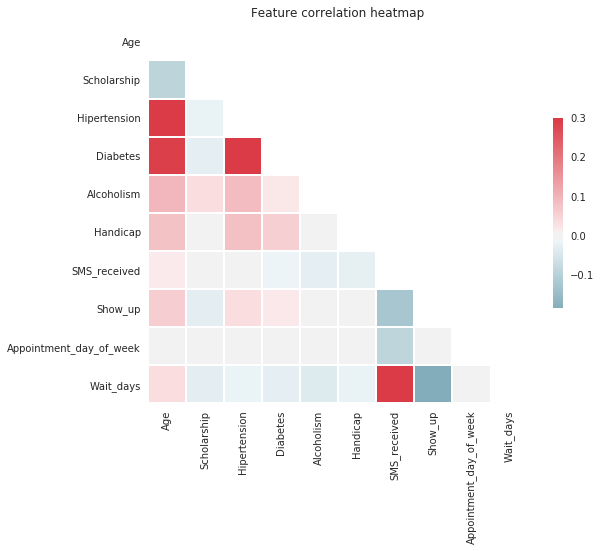

In [18]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
plt.title('Feature correlation heatmap');

In above heat map we can see that `SMS_received` has strong positive relationship with `Wait_days`. It's safe to assume that longer waiting patients are more likely to receive SMS messages. 

Let's see  if that's the case and if long waiting patients are more likely to show up if they received an SMS reminder.

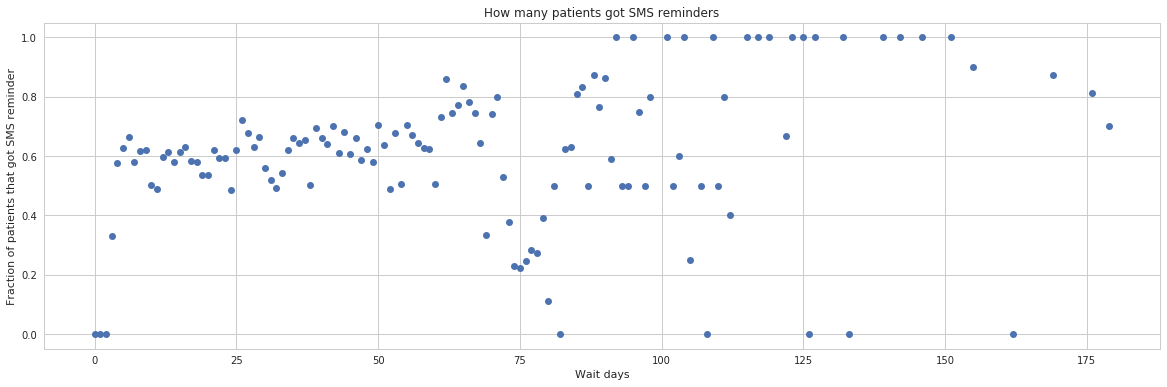

In [19]:
# create dataset with fractions of `SMS_received` and `Show_up` based on `Wait_days`
df_wait_days = df_cleaned[['Wait_days', 'SMS_received']].groupby('Wait_days').mean().reset_index()

#set plot size
fig, ax = plt.subplots(figsize=(20, 6))

# plot `SMS_received` against `Wait_days`
plt.plot(df_wait_days['Wait_days'], df_wait_days['SMS_received'], 'bo')
plt.title('How many patients got SMS reminders')
plt.xlabel('Wait days')
plt.ylabel('Fraction of patients that got SMS reminder');

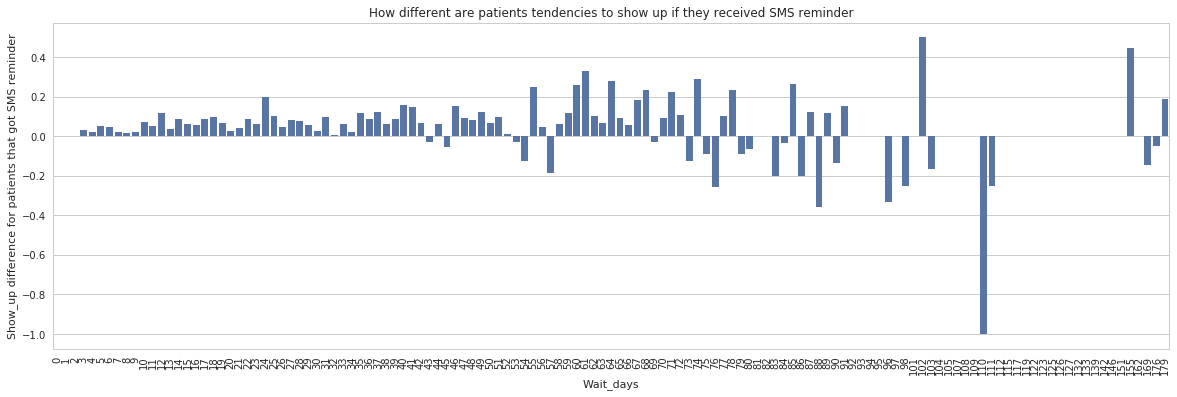

In [20]:
# extract mean `Show_up` based on `Wait_days` and `SMS_received`
df_received = df_cleaned.query('SMS_received == 1')[['Wait_days', 'Show_up']].groupby('Wait_days').mean()
df_not_received = df_cleaned.query('SMS_received == 0')[['Wait_days', 'Show_up']].groupby('Wait_days').mean()

# calculate how much more likely notified patients are to show up
df_show_up_notified = (df_received['Show_up'] - df_not_received['Show_up']).reset_index()

#set plot size
fig, ax = plt.subplots(figsize=(20, 6))

# plot how much more likely patients that received reminder were to show up based on wait time
g = sns.barplot(data=df_show_up_notified, x='Wait_days', y='Show_up', color='b')
g.set_xticklabels(rotation = 90, labels = df_show_up_notified['Wait_days'])
plt.title('How different are patients tendencies to show up if they received SMS reminder')
plt.ylabel('Show_up difference for patients that got SMS reminder');

We can see that notified patients are more likely to show up, but as `Wait_days` grow relationship between `SMS_received` and `Show_up` weakens.

<a id="rq2"></a>
### Research Question 2: Is there association between medical conditions reported in this dataset and patients showing up?

As we already seen in correlation heatmap that medical conditions have very weak correlation to `Show_up`, let'scheck if there's a difference between long waiting and short waiting patients based on `Wait_days`.

Let's use 25 days as a cut-off point for long wait.

In [21]:
# get short waiting patients
df_lt_25d = df_cleaned.query('Wait_days < 25')

# compute correlateion matrix
corr_df_lt_25d = df_lt_25d.corr()

# extract `Show_up` correlations to other features
corr_df_lt_25d_show_up = corr_df_lt_25d.loc[:, ['Show_up']]
corr_df_lt_25d_show_up['abs'] = corr_df_lt_25d_show_up['Show_up'].abs()
corr_df_lt_25d_show_up.sort_values('abs', ascending=False).query('index != "Show_up"')['Show_up']
df_lt_corr = (corr_df_lt_25d_show_up
              .sort_values('abs', ascending=False)
              .query('index != "Show_up"')['Show_up']
              .reset_index()
              .rename(columns={'index': 'Feature',
                               'Show_up': 'Show_up_corr'}))
df_lt_corr

,Feature,Show_up_corr
0,Wait_days,-0.245672
1,SMS_received,-0.134359
2,Age,0.048810
3,Scholarship,-0.031210
4,Hipertension,0.027942
5,Diabetes,0.010035
6,Appointment_day_of_week,-0.010000
7,Handicap,0.003328
8,Alcoholism,-0.001742


In [22]:
# get long waiting patients
df_gte_25d = df_cleaned.query('Wait_days >= 25')

# compute correlateion matrixes
corr_df_gte_25d = df_gte_25d.corr()

# extract `Show_up` correlations to other features
corr_df_gte_25d_show_up = corr_df_gte_25d.loc[:, ['Show_up']]
corr_df_gte_25d_show_up['abs'] = corr_df_gte_25d_show_up['Show_up'].abs()
df_gte_corr = (corr_df_gte_25d_show_up
               .sort_values('abs', ascending=False)
               .query('index != "Show_up"')['Show_up']
               .reset_index()
               .rename(columns={'index': 'Feature',
                                'Show_up': 'Show_up_corr'}))
df_gte_corr

,Feature,Show_up_corr
0,Age,0.121258
1,SMS_received,0.072362
2,Hipertension,0.046948
3,Scholarship,-0.046546
4,Appointment_day_of_week,0.026177
5,Wait_days,0.022241
6,Alcoholism,-0.017126
7,Diabetes,0.015364
8,Handicap,0.007939


* It looks like relationship strengths to `Show_up` of all features are weaker in a long waiting group.
* In short waiting group strongest relationship is `Wait_days`;
* In long waiting group strongest relationship is `Age`;
* What's interesting is `Wait_days` becomes a positive relationship in long waiting group;

Let's compare both groups visually in a bar plot.

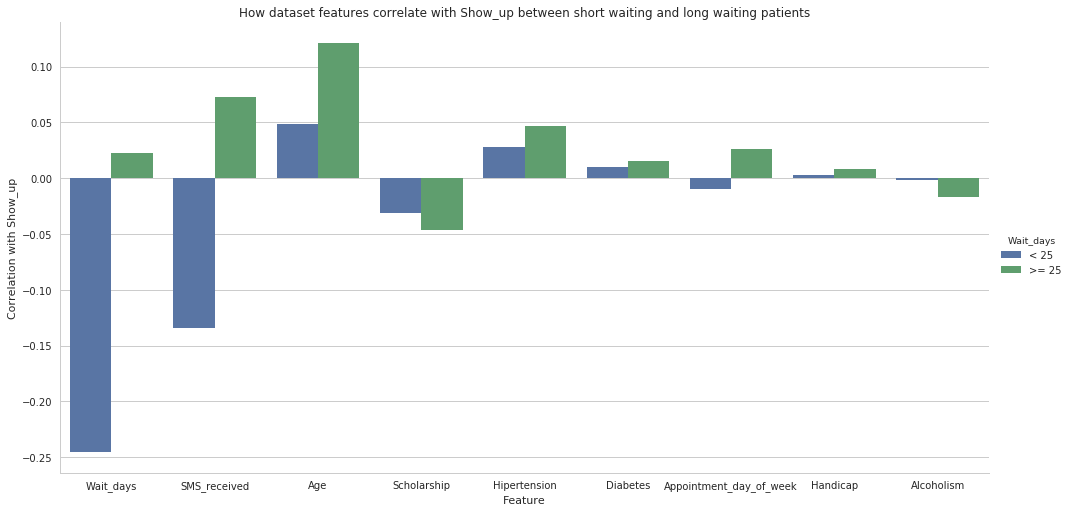

In [23]:
df_lt_corr = df_lt_corr.assign(Wait_days = lambda x: '< 25')
df_gte_corr = df_gte_corr.assign(Wait_days = lambda x: '>= 25')
df_unified = pd.concat([df_lt_corr, df_gte_corr])

g = sns.factorplot(kind='bar', data=df_unified, x='Feature', y='Show_up_corr', hue='Wait_days', size=7, aspect=2)
plt.title('How dataset features correlate with Show_up between short waiting and long waiting patients')
g.set_ylabels('Correlation with Show_up');

<a id="rq3"></a>
### Research Question 3: How tendencies of patients showing up change as number of days patients have to wait for appointment increases?

In correlation heatpam back in <a href="#rq1">question 1</a> it was already evident `Show_up` has a negative relationship to `Wait_days`. ILet's plot a fraction of showed up patients against how many days they had to wait to see this relationship in more detail.

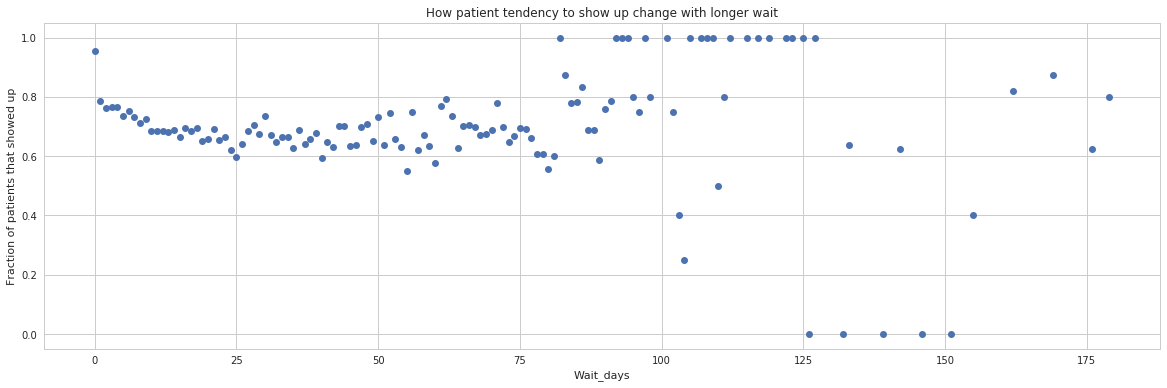

In [24]:
# create dataset with fractions of `Show_up` based on `Wait_days`
df_wait_days = df_cleaned[['Wait_days', 'Show_up']].groupby('Wait_days').mean().reset_index()

#set plot size
fig, ax = plt.subplots(figsize=(20, 6))

# plot `SMS_received` against `Wait_days`
plt.plot(df_wait_days['Wait_days'], df_wait_days['Show_up'], 'bo')
plt.title('How patient tendency to show up change with longer wait')
plt.xlabel('Wait_days')
plt.ylabel('Fraction of patients that showed up');

We can see that for first 25 days `Show_up` follow neatly packed linear trend, but as `Wait_days` keep increasing value points scatter.

<a id="rq4"></a>
### Research Question 4: Do different days of week have different tendencies of patients showing up?

I'll be using non-directional t tests of `p < 0.05` to find days of week that have significantly different `Show_up` tendencies compared to combined tendencies of entire dataset.

Let's start by calculating `Show_up` tendencies for each day in dataset.

In [25]:
df_grouped_by_day = (df_cleaned
                     .groupby(['AppointmentDay',
                               'Appointment_day_of_week',
                               'Appointment_day_of_week_name'])['Show_up']
                     .mean()
                     .reset_index())
df_grouped_by_day

,AppointmentDay,Appointment_day_of_week,Appointment_day_of_week_name,Show_up
0,2016-04-29,4,Friday,0.804328
1,2016-05-02,0,Monday,0.803245
2,2016-05-03,1,Tuesday,0.804935
3,2016-05-04,2,Wednesday,0.766739
4,2016-05-05,3,Thursday,0.811330
5,2016-05-06,4,Friday,0.795050
6,2016-05-09,0,Monday,0.774729
7,2016-05-10,1,Tuesday,0.769731
8,2016-05-11,2,Wednesday,0.802190
9,2016-05-12,3,Thursday,0.809513


Let's group dataset by weekdays and see if any are significantly different.

In [26]:
population = df_grouped_by_day['Show_up']

t_values = (df_grouped_by_day
            .sort_values('Appointment_day_of_week')
            .groupby(['Appointment_day_of_week', 'Appointment_day_of_week_name'])['Show_up']
            .apply(lambda sample: ttest_ind(population, sample))
            .reset_index())
t_values.drop('Appointment_day_of_week', axis=1, inplace=True)
t_values['t'] = t_values['Show_up'].apply(lambda x: x[0])
t_values['p'] = t_values['Show_up'].apply(lambda x: x[1])
t_values.drop('Show_up', axis=1, inplace=True)
t_values.query('p < 0.05').shape[0]

/home/marozas/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/marozas/.local/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0

No `p` values are small enough to reject null hypothesis. There are no days of week with significantly different `Show_up` tendencies.

Let's use a boxplot to visually compare differences.

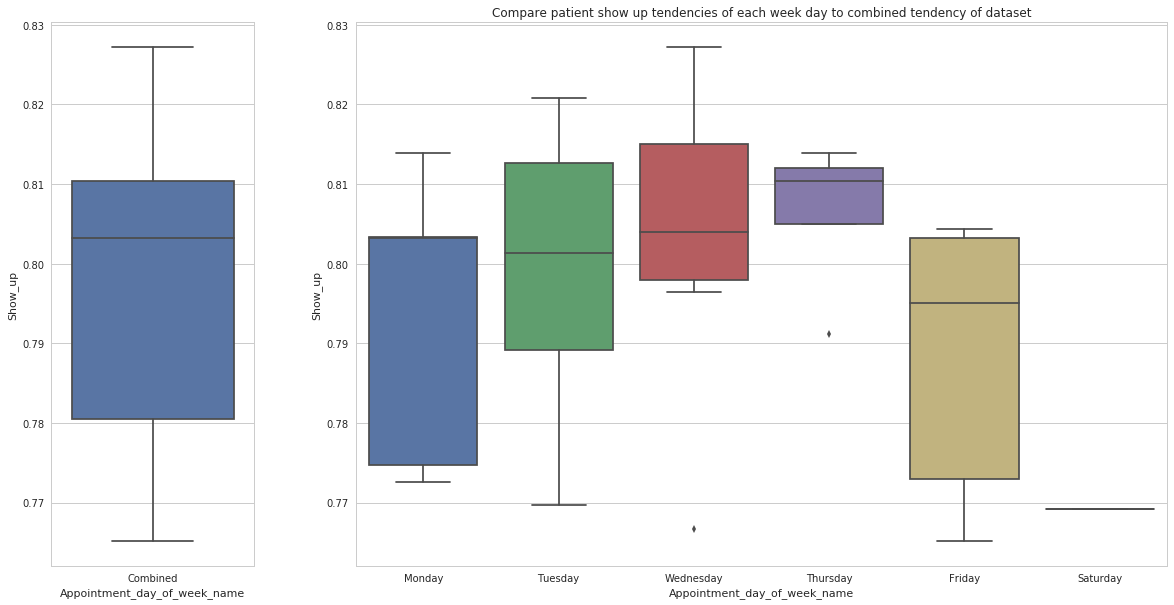

In [27]:
df_total = df_grouped_by_day[['Show_up']].assign(Appointment_day_of_week_name = lambda x: 'Combined')
df_grouped_by_day_sorted = df_grouped_by_day.sort_values('Appointment_day_of_week')

fig, ax = plt.subplots(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 12])

ax0 = plt.subplot(gs[0])
sns.boxplot(x = df_total['Appointment_day_of_week_name'], y = df_total['Show_up'], ax = ax0)

ax1 = plt.subplot(gs[1])
sns.boxplot(x = df_grouped_by_day_sorted['Appointment_day_of_week_name'], y = df_grouped_by_day_sorted['Show_up'], ax = ax1)
plt.title('Compare patient show up tendencies of each week day to combined tendency of dataset');

This is a very interesting distribution, but I was expecting a similar pattern.

Looks like Saturday would have been different, but there's only one Saturday in dataset and this got it a 0 degrees of freedom, raising an error we've seen in the calculation.

<a id="rq5"></a>
### Research Question 5: Are there any neighborhoods with significantly different tenencies of patients showing up?

I'll be using non-directional t tests of `p < 0.05` to find neighbourhoods that have significantly different `Show_up` tendencies compared to combined tendencies of entire dataset.

In [28]:
population = df_cleaned.groupby(['AppointmentDay', 'Neighbourhood'])['Show_up'].mean().reset_index()
t_values = (population
            .groupby('Neighbourhood')['Show_up']
            .apply(lambda sample: ttest_ind(population['Show_up'], sample))
            .reset_index())
t_values['t'] = t_values['Show_up'].apply(lambda x: x[0])
t_values['p'] = t_values['Show_up'].apply(lambda x: x[1])
t_values.drop('Show_up', axis=1, inplace=True)
different_neighbourhoods = t_values.query('p < 0.05')
different_neighbourhoods

/home/marozas/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/marozas/.local/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Neighbourhood,t,p
31,ILHA DO BOI,-3.744886,0.000186
36,ITARARÉ,2.506841,0.012259
48,MÁRIO CYPRESTE,-2.116964,0.034384
61,SANTA CECÍLIA,2.871890,0.004122
62,SANTA CLARA,3.050134,0.002317
70,SANTOS DUMONT,3.436065,0.000602


There are 6 neighbourhoods that are significantly different.

Let's compare them to combined tendencies in a box plot.

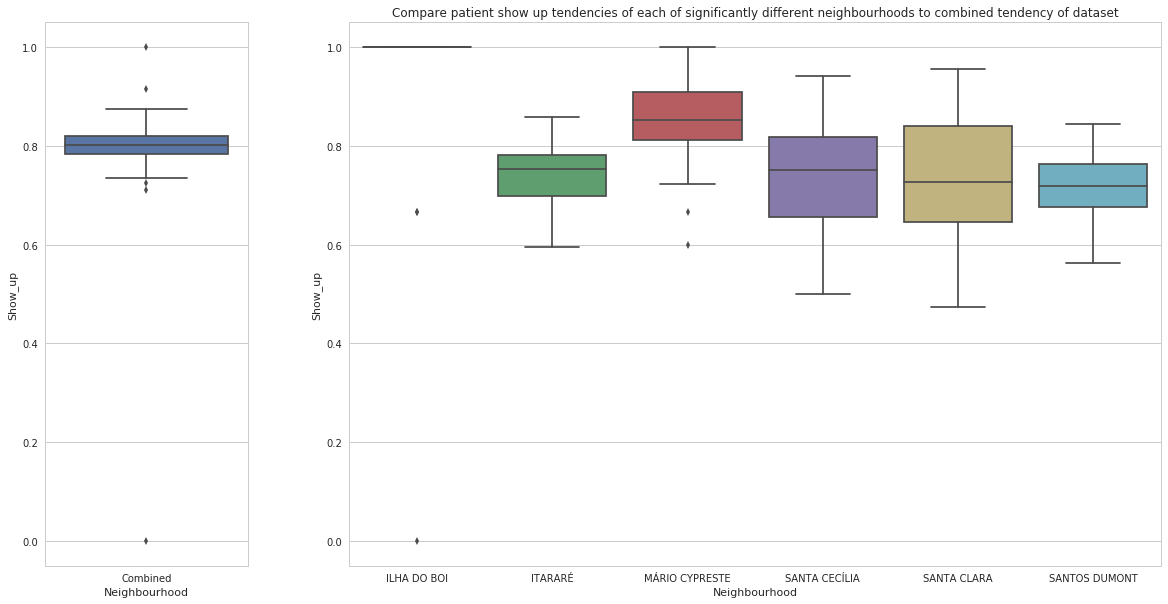

In [29]:
df_total = df_cleaned.groupby('Neighbourhood')['Show_up'].mean().reset_index()
df_total = df_total.assign(Neighbourhood = lambda x: 'Combined')

df_different_neighbourhoods = (df_cleaned[df_cleaned['Neighbourhood']
                                          .isin(different_neighbourhoods['Neighbourhood'])]
                               .groupby(['AppointmentDay', 'Neighbourhood'])['Show_up']
                               .mean()
                               .reset_index())

fig, ax = plt.subplots(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 12])

ax0 = plt.subplot(gs[0])
sns.boxplot(x = df_total['Neighbourhood'], y = df_total['Show_up'], ax = ax0)

ax1 = plt.subplot(gs[1])
sns.boxplot(x = df_different_neighbourhoods['Neighbourhood'], y = df_different_neighbourhoods['Show_up'], ax = ax1)
plt.title('Compare patient show up tendencies of each of significantly different neighbourhoods to combined tendency of dataset');

Let's also boxplot all neighborhoods.

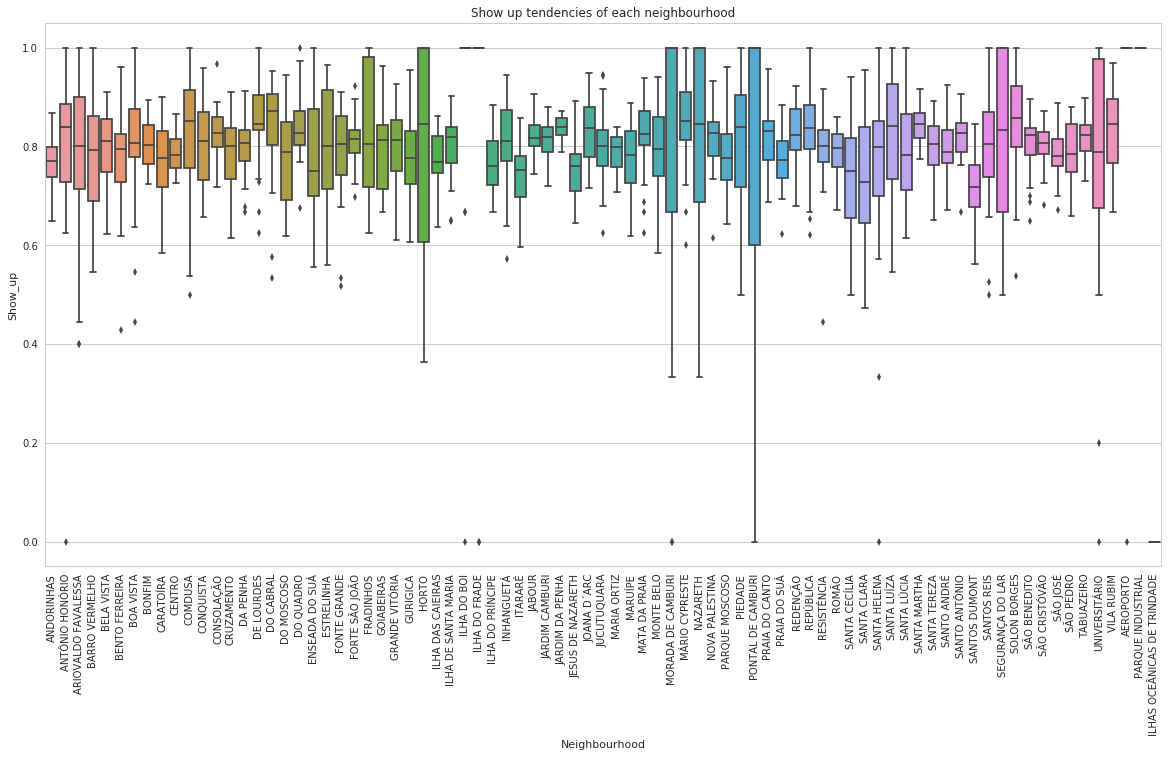

In [30]:
df_neighborhoods = df_cleaned.groupby(['AppointmentDay', 'Neighbourhood'])['Show_up'].mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.boxplot(x = df_neighborhoods['Neighbourhood'], y = df_neighborhoods['Show_up'], ax = ax)
g.set_xticklabels(rotation = 90, labels = df_neighborhoods['Neighbourhood'].unique())
plt.title('Show up tendencies of each neighbourhood');

Neighbourhoods that got flagged as significantly different by the t test don't look different from others. In fact in this graph, visually, they look rather average. This is probably related to a number of samples in each group.

<a id='conclusions'></a>
## Conclusions

After investigating medical appointment no-show dataset I've made these conclusions:

* Major factor of patients missing appointments if long wait;
* Patients that received an SMS reminder are a little more likely to show up;
* Patients are slightly more likely to show up for mid-week appointments;
* Reported medical conditions are not significant factors for patient showing up;
* After a long wait older patients as well as patients with reported medical conditions are slightly more likely to still show up.

There can be many reasons for these tendencies, but we don't have enough datapoints to verify them. Some questions to explore in the future, with more comprehensive dataset could be: 

* Most patients probably get better before the appointments if they have to wait long;
* Older people probably don't get well as quick, or they have other long term conditions not reported in this dataset;
* People with reported conditions might have different patterns in how they schedule their appointments and different reasons to skip them.

In [31]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0